In [27]:
import json
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import norse
import matplotlib.pyplot as plt

In [65]:
### TEST DATA
test_data_path = "data/ds_test.pt"
ds_test = torch.load(test_data_path)

letter_written = ['Space', 'A', 'E', 'I', 'O', 'U', 'Y']
device = "cpu"
### LOSS FUNCTION
loss_fn = torch.nn.functional.cross_entropy
### OPTIMAL HYPERPARAMETERS
parameters_path = "data/parameters_ref_zero.json"

with open(parameters_path) as f:
   parameters = json.load(f)

import nir
nir_graph = nir.read("braille_retrained_zero.nir")
nir_graph

NIRGraph(nodes={'fc1': Affine(weight=array([[-1.33806360e+00,  5.79449013e-02,  1.56500041e-01,
        -8.98946896e-02,  4.30168718e-01, -1.13412477e-01,
        -4.90320265e-01,  3.49327892e-01,  6.17891490e-01,
         6.52276158e-01,  2.66522588e-03, -2.09836102e+00],
       [-1.25033751e-01, -2.51833767e-01, -1.79891467e-01,
        -3.23751152e-01, -1.48391396e-01, -2.94398308e-01,
        -4.33553278e-01, -2.49562204e-01, -3.03823799e-01,
        -1.69630110e-01, -3.65726292e-01, -5.70847355e-02],
       [-5.70042276e+00, -1.43848926e-01, -6.42502487e-01,
         8.02832842e-02,  1.93597808e-01, -2.70732808e+00,
        -1.05163224e-01,  5.95107488e-02,  1.37910172e-02,
        -4.96907711e+00, -1.19294591e-01, -3.27644974e-01],
       [-1.87006846e-01, -3.03020142e-02, -2.01153517e-01,
        -3.32092166e-01, -1.75986573e-01, -3.54239196e-01,
        -1.41495883e-01,  8.16067122e-03, -7.10058063e-02,
        -4.07845587e-01, -7.35815167e-02, -1.37334466e-01],
       [-3.8916

In [66]:
[type(x) for x in nir_graph.nodes.values()]

[nir.ir.Affine,
 nir.ir.Affine,
 nir.ir.Input,
 nir.ir.CubaLIF,
 nir.ir.Affine,
 nir.ir.CubaLIF,
 nir.ir.Output]

In [67]:
net = norse.torch.from_nir(nir_graph, dt=1e-4)
net

GraphExecutor(
  (fc1): Linear(in_features=12, out_features=38, bias=True)
  (fc2): Linear(in_features=38, out_features=7, bias=True)
  (input): Identity()
  (lif1_lif): CubaLIF(
    (synapse): LIBoxCell(
      p=LIBoxParameters(tau_mem_inv=tensor([4500., 4500., 4500., 4500., 4500., 4500., 4500., 4500., 4500., 4500.,
              4500., 4500., 4500., 4500., 4500., 4500., 4500., 4500., 4500., 4500.,
              4500., 4500., 4500., 4500., 4500., 4500., 4500., 4500., 4500., 4500.,
              4500., 4500., 4500., 4500., 4500., 4500., 4500., 4500.]), v_leak=tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])), dt=0.0001
    )
    (lif): LIFBoxCell(
      p=LIFBoxParameters(tau_mem_inv=tensor([1000.0002, 1000.0002, 1000.0002, 1000.0002, 1000.0002, 1000.0002,
              1000.0002, 1000.0002, 1000.0002, 1000.0002, 1000.0002, 1000.0002,
              1000.0002, 10

In [31]:
nir_graph.nodes.keys()

dict_keys(['fc1', 'fc2', 'input', 'lif1.lif', 'lif1.w_rec', 'lif2', 'output'])

# Save activity of first layer

In [78]:
def record_layer1(graph, reset_method):
    net = norse.torch.from_nir(graph, dt=1e-4, reset_method=reset_method)
    lin_out = net.fc1(ds_test[0][0])
    lin_out.shape
    lif1_out = []
    state = None
    for i, t in enumerate(lin_out):
        if i == 0:
            t = t + net.lif1_w_rec.bias
        else:
            t = net.lif1_w_rec(t)
        z, state = net.lif1_lif(t, state)
        lif1_out.append(z)
    return torch.stack(lif1_out).detach()
zero_out = record_layer1("braille_zero.nir", reset_method=norse.torch.functional.reset_value)
zero_out.shape

torch.Size([256, 38])

In [77]:
np.save("norse_activity_zero.npy", zero_out.numpy())

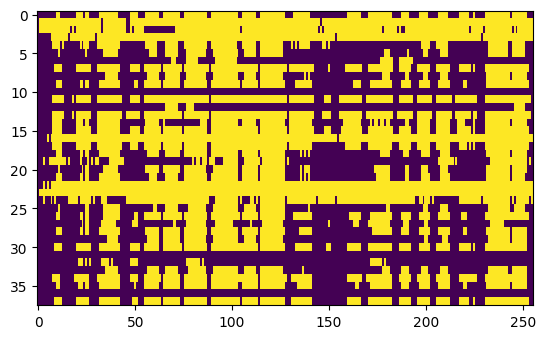

In [79]:
plt.imshow(zero_out.T, interpolation="none", aspect=4)

In [35]:
subtract_out = record_layer1("braille_subtract.nir", reset_method=norse.torch.functional.reset_subtract)
subtract_out.shape
np.save("norse_activity_subtract.npy", zero_out.numpy())

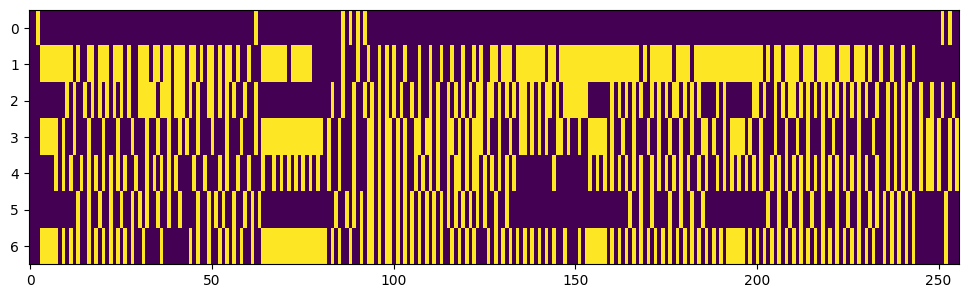

In [68]:
def apply(net, data):
    state = None
    hid_rec = []
    out = []
    for i, t in enumerate(data):
        z, state = net(t, state)
        out.append(z)
        hid_rec.append(state)
    spk_out = torch.stack(out)
    # hid_rec = torch.stack(hid_rec)
    return spk_out, hid_rec
plt.figure(figsize=(12, 4))
plt.imshow(apply(net, ds_test[0][0])[0].detach().T, aspect=10, interpolation="none")

# Run inference

In [10]:
def val_test_loop(dataset, batch_size, net, loss_fn, device, shuffle=True, saved_state_dict=None, label_probabilities=False, regularization=None):
  
  with torch.no_grad():
    if saved_state_dict != None:
        net.load_state_dict(saved_state_dict)
    net.eval()

    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=False)

    batch_loss = []
    batch_acc = []

    for data, labels in loader:
        data = data.to(device).swapaxes(1, 0)
        labels = labels.to(device)

        spk_out, hid_rec = apply(net, data)

        # Validation loss
        if regularization != None:
            # L1 loss on spikes per neuron from the hidden layer
            reg_loss = regularization[0]*torch.mean(torch.sum(hid_rec, 0))
            # L2 loss on total number of spikes from the hidden layer
            reg_loss = reg_loss + regularization[1]*torch.mean(torch.sum(torch.sum(hid_rec, dim=0), dim=1)**2)
            loss_val = loss_fn(spk_out, labels) + reg_loss
        else:
            loss_val = loss_fn(spk_out.sum(0), labels)

        batch_loss.append(loss_val.detach().cpu().item())

        # Accuracy
        act_total_out = torch.sum(spk_out, 0)  # sum over time
        _, neuron_max_act_total_out = torch.max(act_total_out, 1)  # argmax over output units to compare to labels
        batch_acc.extend((neuron_max_act_total_out == labels).detach().cpu().numpy()) # batch_acc.append(np.mean((neuron_max_act_total_out == labels).detach().cpu().numpy()))
    
    if label_probabilities:
        log_softmax_fn = nn.LogSoftmax(dim=-1)
        log_p_y = log_softmax_fn(act_total_out)
        return [np.mean(batch_loss), np.mean(batch_acc)], torch.exp(log_p_y)
    else:
        return [np.mean(batch_loss), np.mean(batch_acc)]

In [47]:
### INFERENCE ON TEST SET

batch_size = 64

input_size = 12 
num_steps = next(iter(ds_test))[0].shape[0]
regularization = [parameters["reg_l1"], parameters["reg_l2"]]

In [48]:
def load_and_val(graph, reset_method):
    net = norse.torch.from_nir(graph, reset_method=reset_method, dt=1e-4)
    return val_test_loop(ds_test, batch_size, net, loss_fn, device, shuffle=False)#, regularization=regularization)    

In [49]:
test_results = load_and_val("braille_subtract.nir", reset_method=norse.torch.functional.reset_subtract)
np.save("norse_accuracy_subtract.npy", np.round(test_results[1]*100,2))
print("Test accuracy: {}%".format(np.round(test_results[1]*100,2)))

Test accuracy: 80.71%


In [50]:
test_results = load_and_val("braille_retrained_zero.nir", reset_method=norse.torch.functional.reset_value)
np.save("norse_accuracy_zero.npy", np.round(test_results[1]*100,2))
print("Test accuracy: {}%".format(np.round(test_results[1]*100,2)))

Test accuracy: 94.29%
